<a href="https://colab.research.google.com/github/mohamedsamir3/AttandenceEdu/blob/main/run_spark_on_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Step 1: Load Dataset in Spark


In [1]:
from pyspark.sql import SparkSession

# Create Spark Session
spark = SparkSession.builder.appName("ML with Spark").getOrCreate()

# Load the dataset
spark_df = spark.read.csv("/content/train.csv", header=True, inferSchema=True)

# Display the schema and data preview
spark_df.printSchema()
spark_df.show(5)


root
 |-- User_ID: integer (nullable = true)
 |-- Product_ID: string (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Age: string (nullable = true)
 |-- Occupation: integer (nullable = true)
 |-- City_Category: string (nullable = true)
 |-- Stay_In_Current_City_Years: string (nullable = true)
 |-- Marital_Status: integer (nullable = true)
 |-- Product_Category_1: integer (nullable = true)
 |-- Product_Category_2: integer (nullable = true)
 |-- Product_Category_3: integer (nullable = true)
 |-- Purchase: integer (nullable = true)

+-------+----------+------+----+----------+-------------+--------------------------+--------------+------------------+------------------+------------------+--------+
|User_ID|Product_ID|Gender| Age|Occupation|City_Category|Stay_In_Current_City_Years|Marital_Status|Product_Category_1|Product_Category_2|Product_Category_3|Purchase|
+-------+----------+------+----+----------+-------------+--------------------------+--------------+------------------+--

# Step 2: Data Preprocessing

## Handle Missing Values:

In [2]:
# Fill missing values with zero for simplicity
spark_df = spark_df.fillna({"Product_Category_2": 0, "Product_Category_3": 0})


## Index and Encode Categorical Features:

In [3]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml import Pipeline

# String indexing categorical features
indexers = [
    StringIndexer(inputCol="Gender", outputCol="Gender_Index"),
    StringIndexer(inputCol="Age", outputCol="Age_Index"),
    StringIndexer(inputCol="City_Category", outputCol="City_Index"),
    StringIndexer(inputCol="Stay_In_Current_City_Years", outputCol="Stay_Index")
]

# One-hot encoding indexed features
encoder = OneHotEncoder(inputCols=["Gender_Index", "Age_Index", "City_Index", "Stay_Index"],
                         outputCols=["Gender_OHE", "Age_OHE", "City_OHE", "Stay_OHE"])

# Apply transformation pipeline
pipeline = Pipeline(stages=indexers + [encoder])
spark_df = pipeline.fit(spark_df).transform(spark_df)


## Assemble Features:


In [4]:
from pyspark.ml.feature import VectorAssembler

# Assemble all features into a single vector
assembler = VectorAssembler(
    inputCols=["Gender_OHE", "Age_OHE", "City_OHE", "Stay_OHE",
               "Occupation", "Marital_Status", "Product_Category_1",
               "Product_Category_2", "Product_Category_3"],
    outputCol="features"
)
spark_df = assembler.transform(spark_df)


# Step 3: Split Dataset

In [5]:
# Split into training and testing datasets
train_df, test_df = spark_df.randomSplit([0.8, 0.2], seed=42)


# Step 4: Train Multiple Models
We will train the following algorithms:
1.   Linear Regression
2.   Random Forest Regressor
1.   Gradient-Boosted Tree Regressor
2.   Decision Tree Regressor



## Linear Regression

In [6]:
from pyspark.ml.regression import LinearRegression

# Initialize Linear Regression
lr = LinearRegression(featuresCol="features", labelCol="Purchase")

# Train the model
lr_model = lr.fit(train_df)

# Evaluate Linear Regression
lr_predictions = lr_model.transform(test_df)
lr_predictions.select("Purchase", "prediction").show(5)


+--------+-----------------+
|Purchase|       prediction|
+--------+-----------------+
|    9938|6829.271145584473|
|    1057|5391.591087174202|
|    1422|5208.388147528772|
|    7882|6606.810433157879|
|   11039|8407.181987235814|
+--------+-----------------+
only showing top 5 rows



## Random Forest Regressor

In [7]:
from pyspark.ml.regression import RandomForestRegressor

# Initialize Random Forest
rf = RandomForestRegressor(featuresCol="features", labelCol="Purchase")

# Train the model
rf_model = rf.fit(train_df)

# Evaluate Random Forest
rf_predictions = rf_model.transform(test_df)
rf_predictions.select("Purchase", "prediction").show(5)


+--------+-----------------+
|Purchase|       prediction|
+--------+-----------------+
|    9938|7629.485114228158|
|    1057|7433.608299367191|
|    1422|7500.207040941085|
|    7882|7500.207040941085|
|   11039|8215.496662686292|
+--------+-----------------+
only showing top 5 rows



## Gradient-Boosted Tree Regressor

In [8]:
from pyspark.ml.regression import GBTRegressor

# Initialize Gradient Boosted Tree
gbt = GBTRegressor(featuresCol="features", labelCol="Purchase")

# Train the model
gbt_model = gbt.fit(train_df)

# Evaluate Gradient Boosted Tree
gbt_predictions = gbt_model.transform(test_df)
gbt_predictions.select("Purchase", "prediction").show(5)


+--------+------------------+
|Purchase|        prediction|
+--------+------------------+
|    9938| 7955.725360754987|
|    1057|1379.8536815306254|
|    1422|1686.9960787323112|
|    7882| 7451.348015020584|
|   11039| 9954.829650388981|
+--------+------------------+
only showing top 5 rows



## Decision Tree Regressor

In [9]:
from pyspark.ml.regression import DecisionTreeRegressor

# Initialize Decision Tree
dt = DecisionTreeRegressor(featuresCol="features", labelCol="Purchase")

# Train the model
dt_model = dt.fit(train_df)

# Evaluate Decision Tree
dt_predictions = dt_model.transform(test_df)
dt_predictions.select("Purchase", "prediction").show(5)


+--------+------------------+
|Purchase|        prediction|
+--------+------------------+
|    9938| 8046.195843525894|
|    1057| 3652.123376863601|
|    1422| 3652.123376863601|
|    7882| 8046.195843525894|
|   11039|10036.408110000637|
+--------+------------------+
only showing top 5 rows



# Step 5: Evaluate Model Performance

### For each model, compute the RMSE (Root Mean Squared Error) and R² (R-squared):

In [10]:
from pyspark.ml.evaluation import RegressionEvaluator

# Initialize evaluator
evaluator = RegressionEvaluator(labelCol="Purchase", predictionCol="prediction", metricName="rmse")

# RMSE for each model
lr_rmse = evaluator.evaluate(lr_predictions)
rf_rmse = evaluator.evaluate(rf_predictions)
gbt_rmse = evaluator.evaluate(gbt_predictions)
dt_rmse = evaluator.evaluate(dt_predictions)

# Print results
print(f"Linear Regression RMSE: {lr_rmse}")
print(f"Random Forest RMSE: {rf_rmse}")
print(f"Gradient-Boosted Tree RMSE: {gbt_rmse}")
print(f"Decision Tree RMSE: {dt_rmse}")


Linear Regression RMSE: 4637.38956659935
Random Forest RMSE: 3906.406655962144
Gradient-Boosted Tree RMSE: 2956.6762806816805
Decision Tree RMSE: 3259.0995677464252


# Step 6: Save the Best Model (Optional)

### Save the model with the best performance for future use:

In [11]:
# Save Random Forest model (if it's the best)
rf_model.write().overwrite().save("path_to_save_rf_model")


# Step 7: Collect Model Metrics


In [12]:
# Evaluate RMSE and R² for all models
rmse_evaluator = RegressionEvaluator(labelCol="Purchase", predictionCol="prediction", metricName="rmse")
r2_evaluator = RegressionEvaluator(labelCol="Purchase", predictionCol="prediction", metricName="r2")

# RMSE
lr_rmse = rmse_evaluator.evaluate(lr_predictions)
rf_rmse = rmse_evaluator.evaluate(rf_predictions)
gbt_rmse = rmse_evaluator.evaluate(gbt_predictions)
dt_rmse = rmse_evaluator.evaluate(dt_predictions)

# R²
lr_r2 = r2_evaluator.evaluate(lr_predictions)
rf_r2 = r2_evaluator.evaluate(rf_predictions)
gbt_r2 = r2_evaluator.evaluate(gbt_predictions)
dt_r2 = r2_evaluator.evaluate(dt_predictions)

# Store metrics
models = ["Linear Regression", "Random Forest", "Gradient Boosted Trees", "Decision Tree"]
rmse_values = [lr_rmse, rf_rmse, gbt_rmse, dt_rmse]
r2_values = [lr_r2, rf_r2, gbt_r2, dt_r2]


# Step 8: Visualize the Comparisons


## RMSE Comparison:

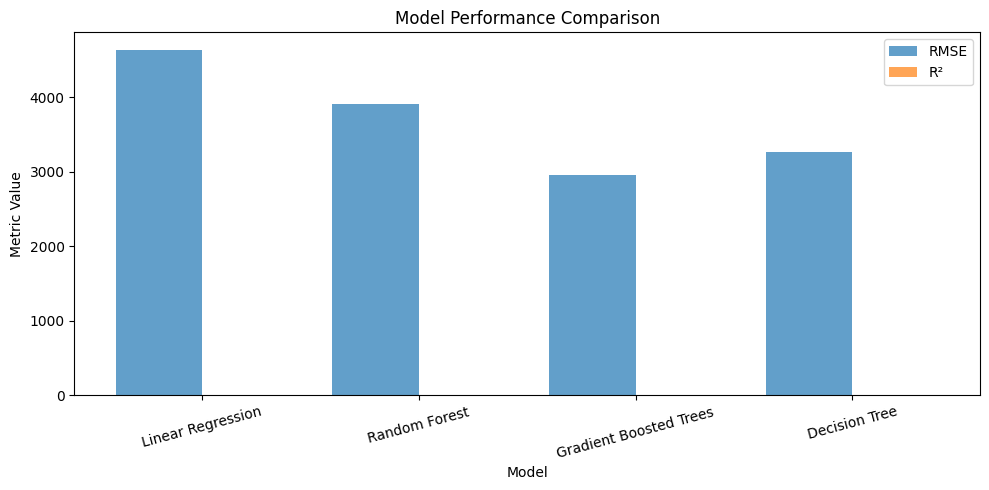

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# Set up bar positions
x = np.arange(len(models))

# Plot RMSE
plt.figure(figsize=(10, 5))
plt.bar(x - 0.2, rmse_values, width=0.4, label='RMSE', alpha=0.7)
plt.bar(x + 0.2, r2_values, width=0.4, label='R²', alpha=0.7)

# Add labels and titles
plt.xticks(x, models, rotation=15)
plt.xlabel("Model")
plt.ylabel("Metric Value")
plt.title("Model Performance Comparison")
plt.legend()

# Show plot
plt.tight_layout()
plt.show()


##  R² Comparison

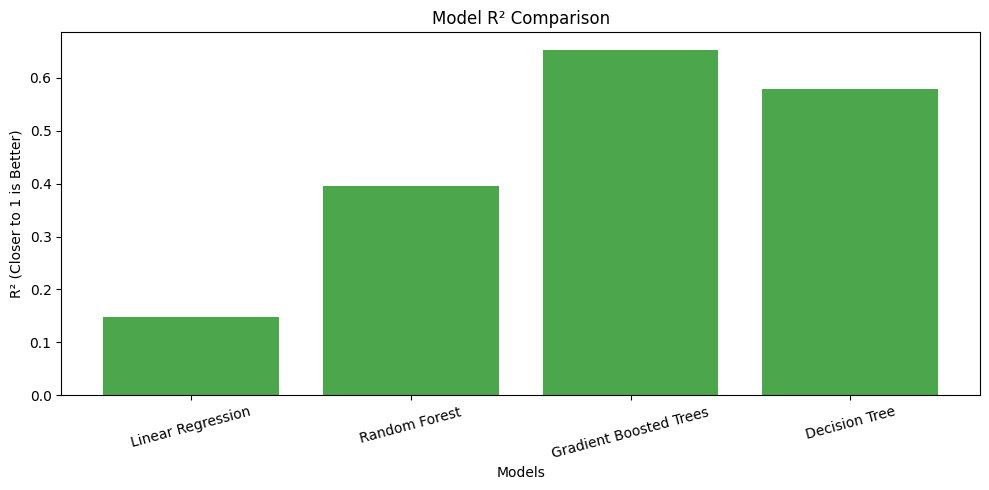

In [14]:
# Plot R² values
plt.figure(figsize=(10, 5))
plt.bar(x, r2_values, color='green', alpha=0.7)
plt.xticks(x, models, rotation=15)
plt.xlabel("Models")
plt.ylabel("R² (Closer to 1 is Better)")
plt.title("Model R² Comparison")
plt.tight_layout()
plt.show()


## Combine RMSE and R² in One Chart

### For a more compact view, we can plot RMSE and R² side-by-side in a grouped bar chart:

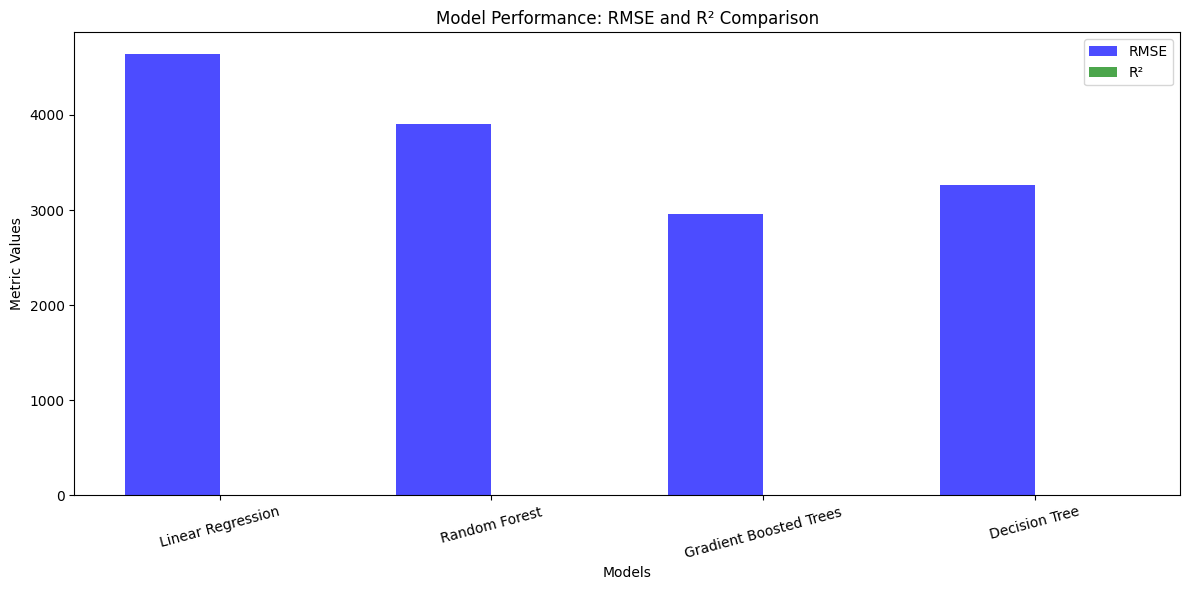

In [15]:
# Combined RMSE and R² chart
plt.figure(figsize=(12, 6))

# Bar width
bar_width = 0.35
x = np.arange(len(models))

# Plot bars
plt.bar(x - bar_width / 2, rmse_values, width=bar_width, label='RMSE', color='blue', alpha=0.7)
plt.bar(x + bar_width / 2, r2_values, width=bar_width, label='R²', color='green', alpha=0.7)

# Labels and Title
plt.xticks(x, models, rotation=15)
plt.xlabel("Models")
plt.ylabel("Metric Values")
plt.title("Model Performance: RMSE and R² Comparison")
plt.legend()
plt.tight_layout()
plt.show()


## Save Visualizations

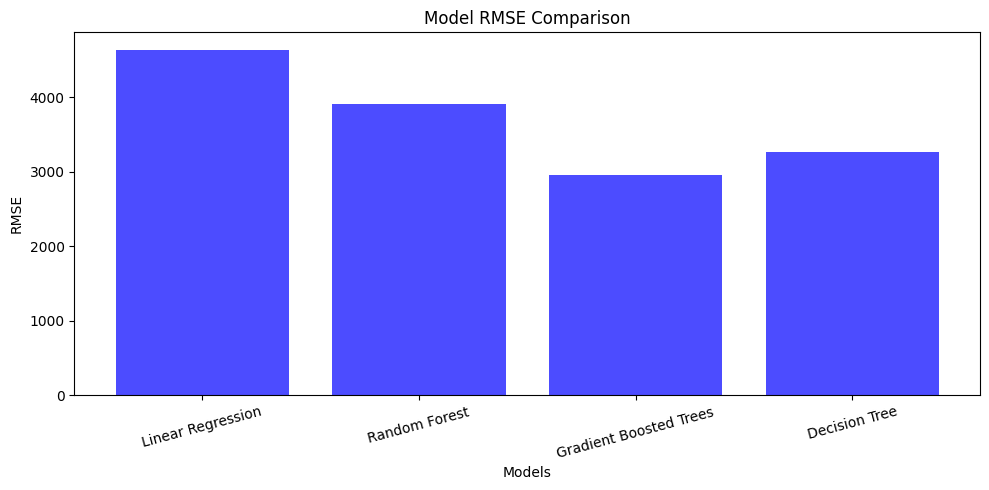

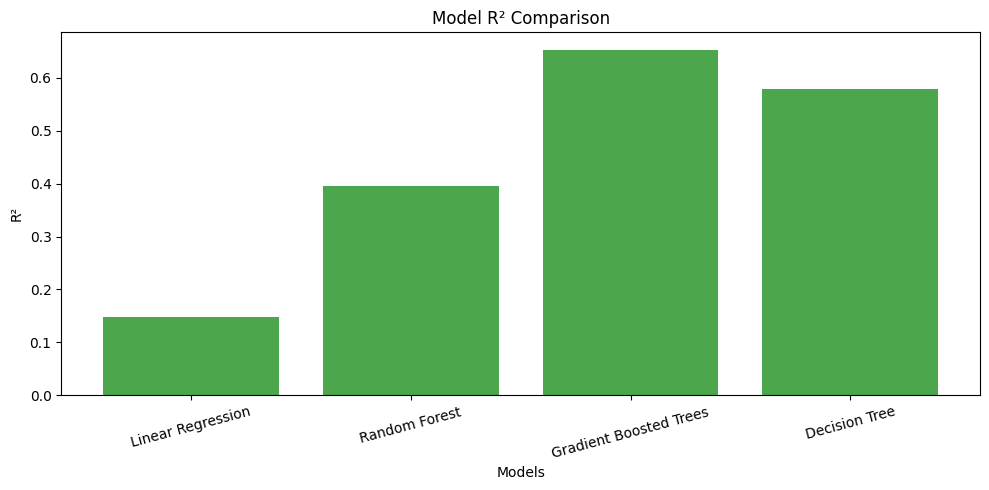

In [16]:
# Save RMSE chart
plt.figure(figsize=(10, 5))
plt.bar(x, rmse_values, color='blue', alpha=0.7)
plt.xticks(x, models, rotation=15)
plt.xlabel("Models")
plt.ylabel("RMSE")
plt.title("Model RMSE Comparison")
plt.tight_layout()
plt.savefig("rmse_comparison.png")

# Save R² chart
plt.figure(figsize=(10, 5))
plt.bar(x, r2_values, color='green', alpha=0.7)
plt.xticks(x, models, rotation=15)
plt.xlabel("Models")
plt.ylabel("R²")
plt.title("Model R² Comparison")
plt.tight_layout()
plt.savefig("r2_comparison.png")
